In [1]:
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
% load_ext autoreload
% autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import numpy as np
import pandas as pd
from pandas.core.dtypes.common import is_string_dtype,is_numeric_dtype
from sklearn.model_selection import train_test_split,KFold,ParameterGrid
from sklearn.ensemble import RandomForestRegressor,forest
from sklearn.metrics import mean_squared_error,mean_absolute_error
from tqdm._tqdm_notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from imp_functions import *

warnings.filterwarnings('ignore')

## Loading Data

Here I load the cleaned data from the data exploration notebook and I also drop jobId which is equivalent to an ID. Hence we can conclusively say that jobId doesnt pay a role in predicting salary

In [2]:
PATH = './data/'
train_df = pd.read_feather(PATH +'corrected_train.feather')
test_df = pd.read_feather(PATH  +'corrected_test.feather')
train_df.drop('jobId',inplace = True,axis=1)
test_df.drop('jobId',inplace = True,axis=1)
type_dict = {'companyId': 'O',
             'degree': 'O',
             'industry': 'O',
             'jobType': 'O',
             'major': 'O',
             'milesFromMetropolis': 'int64',
             'yearsExperience': 'O'}
train_df = train_df.astype(type_dict)
test_df  = test_df.astype(type_dict)
test_df['salary'] = 0

## Feature Engineering

Inspired by the data exploration activities undertaken, I intend to engineer the following feature
1. Label Encoding of categorical features
2. Target mean encoding of categorical features

## Hyper-parameter tuning

### Choosing the number of estimators

In [5]:
kf = KFold(2, random_state=0, shuffle=True)
for train_idx, valid_idx in kf.split(train_df): # Split data into train and test
    kf_train, kf_valid = train_df.iloc[train_idx,:], train_df.iloc[valid_idx,:]
    kf_train.reset_index(inplace=True,drop=True)
    kf_valid.reset_index(inplace=True,drop=True)

initial_params = {'max_features': 'sqrt',
                  'min_samples_leaf': 1,
                  'n_estimators': 200,
                  'n_jobs': -1,
                  'random_state': 42}
cols = ['companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience']

In [9]:
rf_n_estm,_,train_n_estm,test_n_estm = train_model(initial_params,kf_train,
                                                   kf_valid,'salary',cols,valid=False,metric = mean_squared_error)

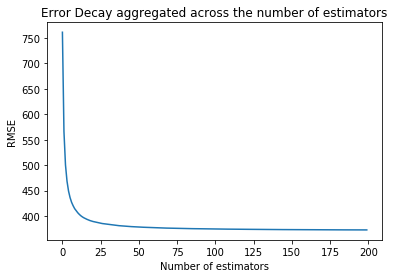

In [10]:
# Next, check the effect of changing the number of trees on the MSE
n_estim_calculate(rf_n_estm,test_n_estm)

### Other Hyperparameters

As we can see that we dont need more than 75 estimators to do get the best result. 

To get the optimal result for other parameters, we would need to tune the hyperparameters using one of the following approaches:
1. **K Fold Cross Validation approach**<br>
2. **Validation approach**

I believe the former approach will enable us to reach the best solution and reduce the chance of overfitting. In the validation set approach, we look at one randomly selected test data and test the performance but it is not as rigourous as , in this approach, every fold is treated as training and testing data. The average errors from all the iterations is minimized to reach the best set of hyperparameters.

In [11]:
# selected number of trees 
n_est_selected = 75

In [12]:
grid = {
    'min_samples_leaf': [5,10,15,25,30,50,75,100],
    'max_features': ['sqrt', 'log2', 'auto', 0.5, 0.25, 0.75,1],
    'n_estimators': [n_est_selected],
    'n_jobs': [-1],
    'random_state': [42]
}

scores = perform_regularised_cv(train_df,'salary',grid,cols,metric=mean_squared_error)

100%|██████████| 56/56 [1:24:34<00:00, 90.61s/it]


In [16]:
pd.DataFrame(scores).sort_values(by=1).loc[:10,:]

,0,1
27,"{'max_features': 0.5, 'min_samples_leaf': 25, ...",363.645397
28,"{'max_features': 0.5, 'min_samples_leaf': 30, ...",363.671848
44,"{'max_features': 0.75, 'min_samples_leaf': 30,...",364.226534
43,"{'max_features': 0.75, 'min_samples_leaf': 25,...",364.426698
26,"{'max_features': 0.5, 'min_samples_leaf': 15, ...",364.537207
29,"{'max_features': 0.5, 'min_samples_leaf': 50, ...",364.594981
45,"{'max_features': 0.75, 'min_samples_leaf': 50,...",364.686958
2,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",364.778045
34,"{'max_features': 0.25, 'min_samples_leaf': 15,...",364.778045
10,"{'max_features': 'log2', 'min_samples_leaf': 1...",364.778045


In [14]:
best_params = pd.DataFrame(scores).sort_values(by=1)
best_params.reset_index(drop=True,inplace=False)
best_parameters = best_params.iloc[0,0]
best_parameters 

{'max_features': 0.5,
 'min_samples_leaf': 25,
 'n_estimators': 75,
 'n_jobs': -1,
 'random_state': 42}

Now that we have identified the best parameters, I will build my final model by training it on the entire dataset. 

In [18]:
# Average RMSE score for cross validation 
np.sqrt(pd.DataFrame(scores).sort_values(by=1).loc[0,1])

19.146719253930577

## Final Model and test predictions

In [15]:
final_model,_,train,test = train_model(best_parameters,train_df,test_df,'salary',cols,valid=False,metric = mean_squared_error)
final_predictions = final_model.predict(test.drop('salary',axis=1))

In [19]:
final_predictions

array([ 113.31172136,   93.46512745,  178.28930499, ...,   56.38010863,
        163.39746703,  114.24387036])

In [3]:
test_df = pd.read_feather(PATH  +'corrected_test.feather')

In [6]:
test_df['salary'] = final_predictions

In [10]:
test_df.loc[:,['jobId','salary']].to_csv('test_salaries.csv',index=False)